In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Load dataset

In [4]:
df = pd.read_csv('yelp.csv')
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
df.tail()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
9995,VY_tvNUCCXGXQeSvJl757Q,2012-07-28,Ubyfp2RSDYW0g7Mbr8N3iA,3,First visit...Had lunch here today - used my G...,review,_eqQoPtQ3e3UxLE4faT6ow,1,2,0
9996,EKzMHI1tip8rC1-ZAy64yg,2012-01-18,2XyIOQKbVFb6uXQdJ0RzlQ,4,Should be called house of deliciousness!\n\nI ...,review,ROru4uk5SaYc3rg8IU7SQw,0,0,0
9997,53YGfwmbW73JhFiemNeyzQ,2010-11-16,jyznYkIbpqVmlsZxSDSypA,4,I recently visited Olive and Ivy for business ...,review,gGbN1aKQHMgfQZkqlsuwzg,0,0,0
9998,9SKdOoDHcFoxK5ZtsgHJoA,2012-12-02,5UKq9WQE1qQbJ0DJbc-B6Q,2,My nephew just moved to Scottsdale recently so...,review,0lyVoNazXa20WzUyZPLaQQ,0,0,0
9999,pF7uRzygyZsltbmVpjIyvw,2010-10-16,vWSmOhg2ID1MNZHaWapGbA,5,4-5 locations.. all 4.5 star average.. I think...,review,KSBFytcdjPKZgXKQnYQdkA,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


No missing values :)

### Visualize Data

In [8]:
# get length character of text
df['length'] = df.text.apply(len)

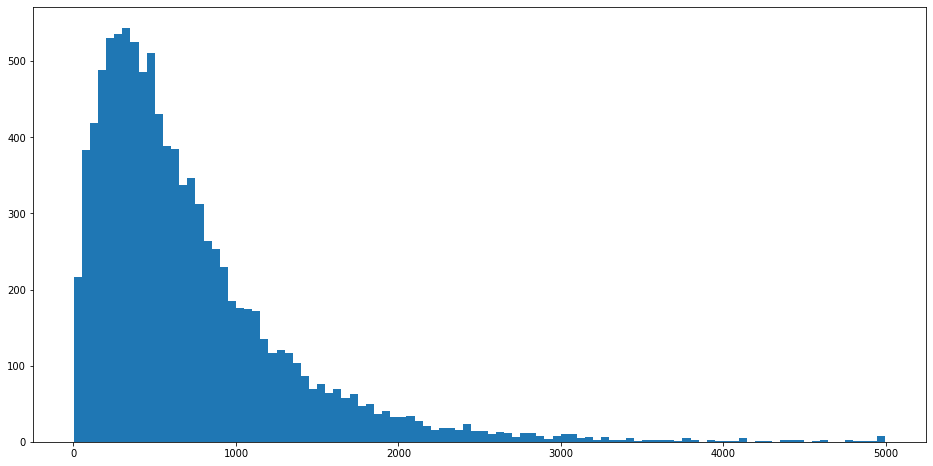

In [9]:
plt.figure(figsize=(16, 8))
plt.hist(df.length, bins=100)
plt.show()

In [10]:
df.length.describe()

count    10000.000000
mean       710.738700
std        617.399827
min          1.000000
25%        294.000000
50%        541.500000
75%        930.000000
max       4997.000000
Name: length, dtype: float64

<Figure size 1152x576 with 0 Axes>

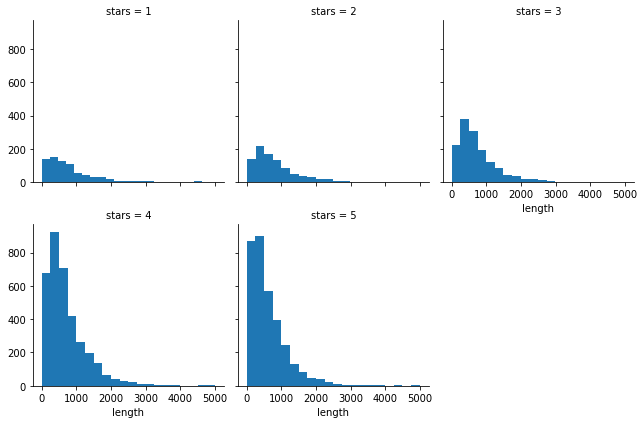

In [12]:
# plot length distribution based on reviews
plt.figure(figsize=(16, 8))
g = sns.FacetGrid(df, col='stars', col_wrap=3)
g.map(plt.hist, 'length', bins=20)
plt.show()

### Data Preparation

In [13]:
# take only extreme stars (1 and 5)
new_df = df[(df['stars'] == 1) | (df['stars'] == 5)]
new_df.shape

(4086, 11)

In [20]:
print(f'Percentage 1 star: {len(new_df[new_df.stars == 1]) / len(new_df) * 100:.3f}')
print(f'Percentage 5 star: {len(new_df[new_df.stars == 5]) / len(new_df) * 100:.3f}')

Percentage 1 star: 18.331
Percentage 5 star: 81.669


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


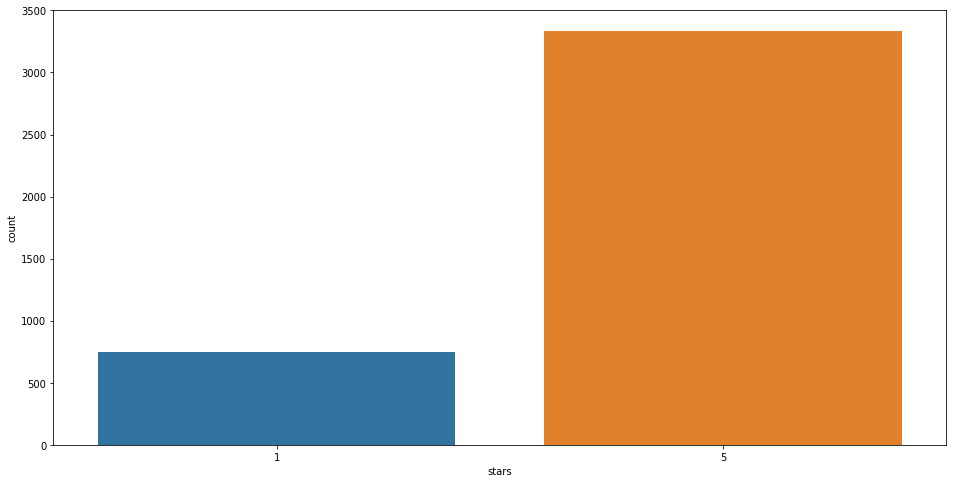

In [22]:
plt.figure(figsize=(16, 8))
sns.countplot(new_df['stars'])
plt.show()

Remove Punctuations

In [24]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Remove Stopwords

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
from nltk.corpus import stopwords

In [32]:
def clean_msg(msg):
    cm = [word for word in ''.join([char for char in msg if char not in string.punctuation]).split() if word.lower() not in stopwords.words('english')]
    return cm

Count Vectorizer

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
countvec = CountVectorizer(analyzer=clean_msg)

In [46]:
X_vec = countvec.fit_transform(new_df.text.values)

Train / Test Split

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
y = new_df.stars.values

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.3)

### Model Train and Evaluation

In [50]:
from sklearn.naive_bayes import MultinomialNB

In [51]:
def build_train_model(X, y):
    m = MultinomialNB()
    m.fit(X, y)
    return m

#### Using all data

In [52]:
model = build_train_model(X_vec, y)

In [53]:
test_sample = countvec.transform(['this is too good', "it's very bad"])
model.predict(test_sample)

array([5, 5])

#### Using train test split

In [54]:
model = build_train_model(X_train, y_train)

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
def evaluate_model(m, X_test, y_test):
    y_pred = m.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, linewidths=0.5)
    return classification_report(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.87      0.64      0.74       238
           5       0.92      0.98      0.95       988

    accuracy                           0.91      1226
   macro avg       0.89      0.81      0.84      1226
weighted avg       0.91      0.91      0.91      1226



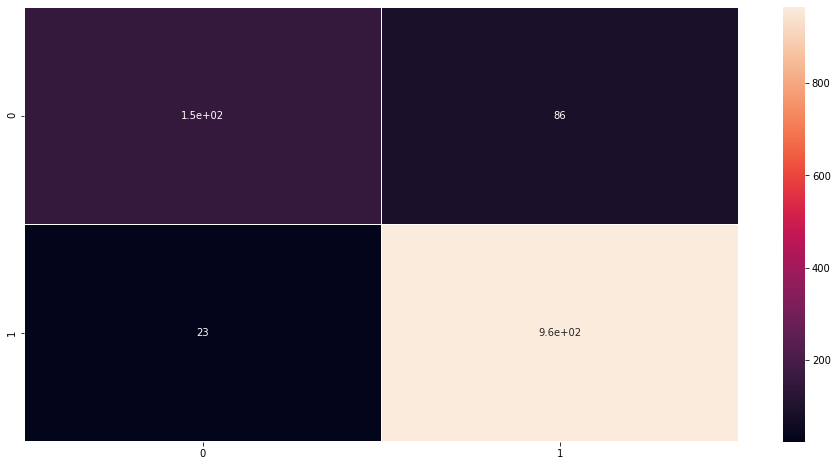

In [57]:
print(evaluate_model(model, X_test, y_test))

### Model Train and Evaluation With TF-IDF

In [61]:
from sklearn.feature_extraction.text import TfidfTransformer

In [62]:
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_vec)
print(X_tfidf.shape)

(4086, 26435)


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3)

Use all data

In [64]:
model = build_train_model(X_tfidf, y)
model.predict(test_sample)

array([5, 5])

Use train test split data

In [65]:
model = build_train_model(X_train, y_train)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       213
           5       0.83      1.00      0.90      1013

    accuracy                           0.83      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.68      0.83      0.75      1226



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


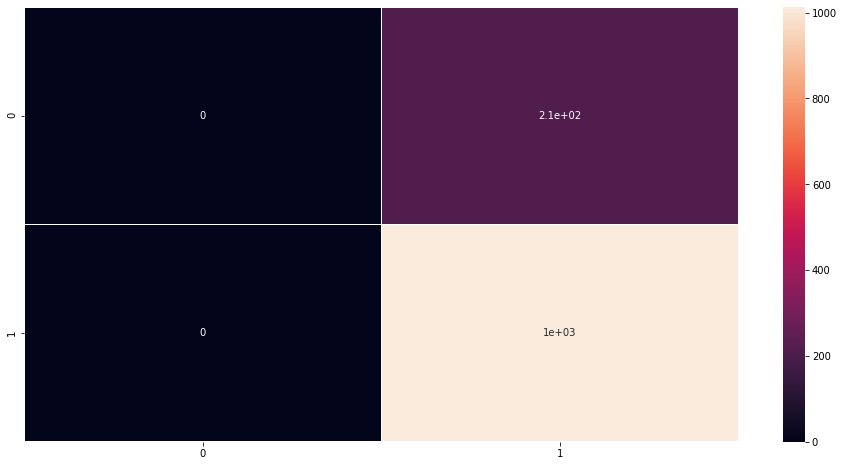

In [66]:
print(evaluate_model(model, X_test, y_test))